# Week 4: Logistic Regression and Feature Scaling
Include concepts such as logistic regression and feature scaling.

In [1]:
# Standard Libraries
import os
import time
import math
import io
import zipfile
import requests
import kagglehub
from urllib.parse import urlparse
from itertools import chain, combinations
from collections import Counter
import re

# Data Science Libraries
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.ticker as mticker
import seaborn as sns

# Scikit-learn (Machine Learning)
from sklearn.model_selection import (
    train_test_split, 
    cross_val_score, 
    GridSearchCV, 
    RandomizedSearchCV, 
    RepeatedKFold,
    RepeatedStratifiedKFold
)
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.feature_selection import SequentialFeatureSelector, f_regression, SelectKBest
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, LogisticRegression
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn import decomposition
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import make_pipeline

# Progress Tracking
from tqdm import tqdm

# Language Processing
from textblob import TextBlob
from datetime import datetime, timedelta
import string

# globals
random_state = 42

In [2]:
# Function for feature scaling with normalization
def feature_scaling_normalization(df):
    denominator = df.max() - df.min()
    denominator_replaced = denominator.replace(0, 1)  # avoid division by zero
    return (df - df.min()) / denominator_replaced

In [3]:
# Function for feature scaling with standardization
def feature_scaling_standardization(df):
    std = df.std(ddof=0) # ddof=0 gives population standard deviation
    std_replaced = std.replace(0, 1)  # avoid division by zero
    return (df - df.mean()) / std_replaced

In [4]:
def logistic_regression_with_scaling(df, target_column, scaling="standardize"):
    # separate features and target
    X = df.drop(columns=[target_column])
    y = df[target_column]

    # apply scaling
    if scaling == "normalize":
        X = feature_scaling_normalization(X.copy())
    elif scaling == "standardize":
        X = feature_scaling_standardization(X.copy())
    else:
        raise ValueError("scaling must be 'normalize' or 'standardize'")

    # train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # logistic regression
    model = LogisticRegression()
    model.fit(X_train, y_train)

    # predictions & accuracy
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)

    return model, acc

## Dataset 1: Web Page Phishing Detection

In [5]:
# Load cleaned data
cleaned_webpage = pd.read_csv('cleaned_webpage.csv')
cleaned_webpage.head()

,length_url,length_hostname,ip,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,nb_or,nb_eq,...,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank,legitimate
0,37,19,0,3,0,0,0,0,0,0,...,0,1,0,45,0,0,1,1,4,1
1,77,23,1,1,0,0,0,0,0,0,...,1,0,0,77,5767,0,0,1,2,0
2,126,50,1,4,1,0,1,2,0,3,...,1,0,0,14,4004,5828815,0,1,0,0
3,18,11,0,2,0,0,0,0,0,0,...,1,0,0,62,0,107721,0,0,3,1
4,55,15,0,2,2,0,0,0,0,0,...,0,1,0,224,8175,8725,0,0,6,1


In [6]:
model1a, acc1a = logistic_regression_with_scaling(cleaned_webpage, "legitimate", scaling="standardize")
print(f"Logistic Regression Accurracy (w/ Standardization): {acc1a:.4f}")

model1b, acc1b = logistic_regression_with_scaling(cleaned_webpage, "legitimate", scaling="normalize")
print(f"Logistic Regression Accurracy (w/ Normalization): {acc1b:.4f}")

Logistic Regression Accurracy (w/ Standardization): 0.9558
Logistic Regression Accurracy (w/ Normalization): 0.9449


## Dataset 2: Phishing Email Detection

In [7]:
# Load cleaned data
cleaned_email = pd.read_csv('cleaned_phishing_email.csv')
cleaned_email.head()

,polarity,subjectivity,unique_words,char_count,word_count,uppercase_ratio,symbol_ratio,kw_urgent,kw_verify,kw_account,kw_click,kw_suspend,kw_update,kw_login,kw_confirm,currency_symbol_count,phone_number_count,Safe Email
0,0.201493,0.514213,110.0,1030.0,230.0,0.000000,0.059223,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,0.009375,0.084375,53.0,479.0,91.0,0.000000,0.037578,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,0.091540,0.515783,102.0,1245.0,305.0,0.000000,0.077108,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,0.260069,0.690278,73.0,688.0,96.0,0.056686,0.162791,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0
4,0.152579,0.505258,60.0,441.0,91.0,0.000000,0.061224,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [8]:
model2a, acc2a = logistic_regression_with_scaling(cleaned_email, "Safe Email", scaling="standardize")
print(f"Logistic Regression Accurracy (w/ Standardization): {acc2a:.4f}")

model2b, acc2b = logistic_regression_with_scaling(cleaned_email, "Safe Email", scaling="normalize")
print(f"Logistic Regression Accurracy (w/ Normalization): {acc2b:.4f}")

Logistic Regression Accurracy (w/ Standardization): 0.7191
Logistic Regression Accurracy (w/ Normalization): 0.7034


## Dataset 3: Credit Card Transactions Fraud Detection Dataset

In [9]:
# Load cleaned data
cleaned_credit_card = pd.read_csv('cleaned_credit_card.csv')
cleaned_credit_card.head()

,category,amt,gender,city,state,lat,long,city_pop,job,unix_time,merch_lat,merch_long,age,max_repeats,is_fraud
0,0,2.86,0,0,0,33.9659,-80.9355,333497,0,1371816865,33.986391,-81.200714,57,3,0
1,0,29.84,1,1,1,40.3207,-110.4360,302,1,1371816873,39.450498,-109.960431,35,4,0
2,1,41.28,1,2,2,40.6729,-73.5365,34496,2,1371816893,40.495810,-74.196111,54,4,0
3,2,60.05,0,3,3,28.5697,-80.8191,54767,3,1371816915,28.812398,-80.883061,38,4,0
4,3,3.19,0,4,4,44.2529,-85.0170,1126,4,1371816917,44.959148,-85.884734,70,3,0


In [10]:
model3a, acc3a = logistic_regression_with_scaling(cleaned_credit_card, "is_fraud", scaling="standardize")
print(f"Logistic Regression Accurracy (w/ Standardization): {acc3a:.4f}")

model3b, acc3b = logistic_regression_with_scaling(cleaned_credit_card, "is_fraud", scaling="normalize")
print(f"Logistic Regression Accurracy (w/ Normalization): {acc3b:.4f}")

Logistic Regression Accurracy (w/ Standardization): 0.9944
Logistic Regression Accurracy (w/ Normalization): 0.9949


## Summary

In [11]:
summary = pd.DataFrame({'Dataset': [1, 2, 3], 'Standardized':[acc1a, acc2a, acc3a], 'Normalized': [acc1b, acc2b, acc3b]})
print('Logistic Regression Accuracy Scores')
print('-'*35)
print(summary.to_string(index=False))
print('-'*35)

Logistic Regression Accuracy Scores
-----------------------------------
 Dataset  Standardized  Normalized
       1      0.955818    0.944882
       2      0.719148    0.703376
       3      0.994407    0.994880
-----------------------------------


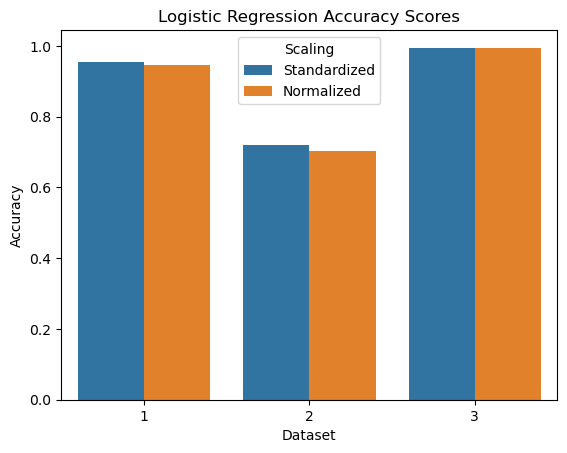

In [12]:
# Create Visualization
summary_melted = summary.melt(id_vars="Dataset", 
                              value_vars=["Standardized", "Normalized"], 
                              var_name="Scaling", 
                              value_name="Accuracy")

sns.barplot(x='Dataset', y='Accuracy', hue='Scaling', data=summary_melted)
plt.title("Logistic Regression Accuracy Scores")
plt.show()